In [1]:
import copy
import math
import random
import time
import os
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init
from IPython.display import Audio, display
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)

# Check for MPS (Apple Silicon GPU) first since we're on Mac
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU") 
else:
    device = torch.device("cpu")
    print("Using CPU")

device

Using CPU


device(type='cpu')

## Load the dataset
Data can be downloaded from http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

In [3]:
data_path = Path('data/speech_commands_v0.01')

testing_hashset = set([
    file_name.strip() for file_name in open(data_path / 'testing_list.txt', 'r')
])
validation_hashset = set([
    file_name.strip() for file_name in open(data_path / 'validation_list.txt', 'r')
])

train_ = []
valid_ = []
test_ = []
for root, _, files in os.walk(data_path):
    if root.endswith('_background_noise_'):
        continue
    root_path = Path(root)
    label = os.path.basename(root)
    for file in files:
        if not file.endswith('.wav'):
            continue
        labelled_file = label + '/' + file
        file_path = root_path / file
        data_entry = {
            'file_path': file_path,
            'label': label
        }
        if labelled_file in testing_hashset:
            test_.append(data_entry)
        elif labelled_file in validation_hashset:
            valid_.append(data_entry)
        else:
            train_.append(data_entry)

print(f'training list has {len(train_)} elements')
print(f'testing list has {len(test_)} elements')
print(f'validation list has {len(valid_)} elements')

training list has 51088 elements
testing list has 6835 elements
validation list has 6798 elements


In [4]:
background_noise_list = []
for root, _, files in os.walk(data_path / '_background_noise_'):
    root_path = Path(root)
    for file in files:
        if not file.endswith('.wav'):
            continue
        data_entry = {
            'file_path': root_path / file,
            'label': file[:-4]
        }
        background_noise_list.append(data_entry)
print(f'background noise files: {[noise["label"] for noise in background_noise_list]}')

background noise files: ['running_tap', 'doing_the_dishes', 'pink_noise', 'exercise_bike', 'white_noise', 'dude_miaowing']


## (optional) Trim the dataset
Use stratified split for stable class distribution

In [5]:
from collections import Counter
from sklearn.model_selection import train_test_split

def get_trimmed_dataset(dataset, trim=0.1, seed=0, verbose=True):
    class_distribution = Counter([entry['label'] for entry in dataset])
    if verbose:
        print(f"Original dataset size: {len(dataset)}")
        print(class_distribution)

    filtered_labels = {label for label, count in class_distribution.items() if count >= 2}
    X = [entry['file_path'] for entry in dataset]
    y = [entry['label'] for entry in dataset]

    X_trimmed, _, y_trimmed, _ = train_test_split(X, y, stratify=y, test_size=(1 - trim), random_state=seed)

    dataset = [{'file_path': entry[0], 'label': entry[1]} for entry in zip(X_trimmed, y_trimmed)]

    if verbose:
        print(f"Trimmed dataset size: {len(dataset)}")
        class_distribution = Counter([entry['label'] for entry in dataset])
        print(class_distribution)

    return dataset

trim_size = 0.2
test_ = get_trimmed_dataset(test_, trim=trim_size, seed=seed)
train_ = get_trimmed_dataset(train_, trim=trim_size, seed=seed)
valid_ = get_trimmed_dataset(valid_, trim=trim_size, seed=seed)

Original dataset size: 6835
Counter({'up': 272, 'five': 271, 'left': 267, 'three': 267, 'two': 264, 'off': 262, 'nine': 259, 'right': 259, 'eight': 257, 'yes': 256, 'four': 253, 'down': 253, 'no': 252, 'go': 251, 'zero': 250, 'stop': 249, 'one': 248, 'on': 246, 'six': 244, 'seven': 239, 'tree': 193, 'sheila': 186, 'dog': 180, 'happy': 180, 'bed': 176, 'cat': 166, 'wow': 165, 'marvin': 162, 'bird': 158, 'house': 150})
Trimmed dataset size: 1367
Counter({'three': 54, 'up': 54, 'five': 54, 'two': 53, 'left': 53, 'right': 52, 'nine': 52, 'off': 52, 'down': 51, 'four': 51, 'eight': 51, 'yes': 51, 'go': 50, 'no': 50, 'one': 50, 'stop': 50, 'zero': 50, 'on': 49, 'six': 49, 'seven': 48, 'tree': 39, 'sheila': 37, 'happy': 36, 'dog': 36, 'bed': 35, 'cat': 33, 'wow': 33, 'marvin': 32, 'bird': 32, 'house': 30})
Original dataset size: 51088
Counter({'one': 1892, 'stop': 1885, 'nine': 1875, 'seven': 1875, 'two': 1873, 'zero': 1866, 'on': 1864, 'six': 1863, 'go': 1861, 'yes': 1860, 'no': 1853, 'right

## Labels preprocessing

In [6]:
id2label = {
    0: 'down',
    1: 'go',
    2: 'left',
    3: 'no',
    4: 'off',
    5: 'on',
    6: 'right',
    7: 'stop',
    8: 'up',
    9: 'yes',
    10: 'unknown'
}

label2id = {label: i for i, label in id2label.items()}

def preprocess_function(instance):
    instance['old_label'] = instance['label']
    instance['label_id'] = label2id.get(instance['label'], label2id['unknown'])
    instance['label'] = id2label[instance['label_id']]
    return instance

train = [preprocess_function(entry) for entry in train_]
test = [preprocess_function(entry) for entry in test_]
valid = [preprocess_function(entry) for entry in valid_]

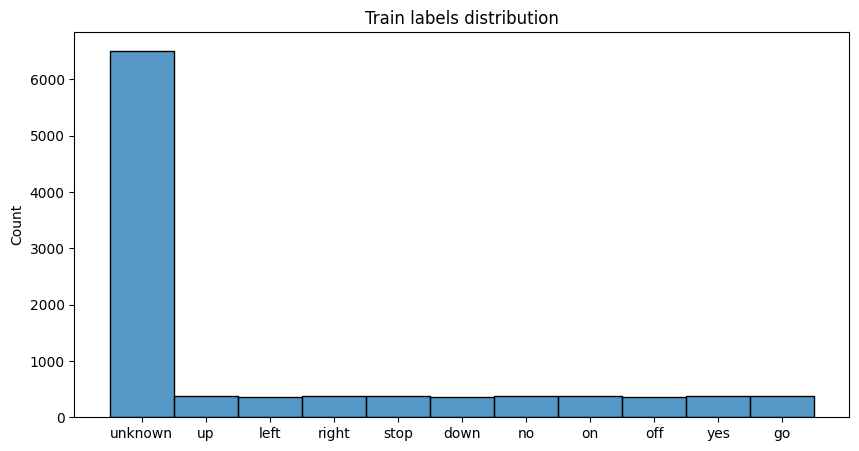

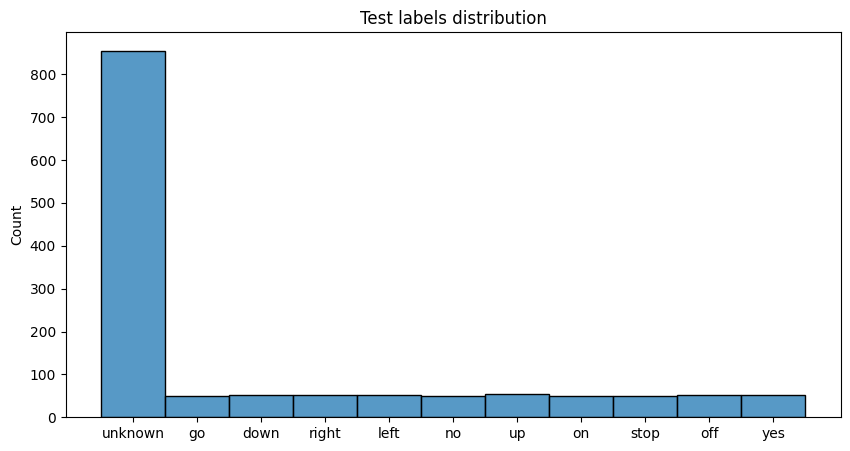

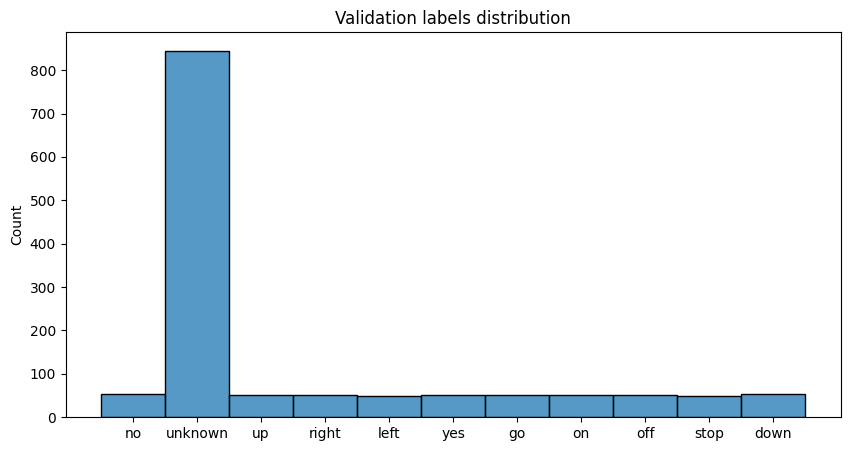

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in train])
plt.title("Train labels distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in test])
plt.title("Test labels distribution")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot([entry['label'] for entry in valid])
plt.title("Validation labels distribution")
plt.show()

### Reduce unkown label count
There's too many unknown labels, making the dataset unbalanced.

In [8]:
def reduce_unknown_to_target(dataset, target_ratio=0.2):
    total_samples = len(dataset)
    known_samples = len([entry for entry in dataset if entry['label'] != 'unknown'])
    unknown_samples = total_samples - known_samples
    current_ratio = unknown_samples / total_samples
    
    # If current ratio is already lower than target, no need to reduce
    if current_ratio <= target_ratio:
        print(f"No reduction needed. Current unknown ratio: {current_ratio:.2%}")
        return dataset
    
    unknown_to_keep = int(known_samples * target_ratio / (1 - target_ratio))
    
    unknown_indices = [i for i, entry in enumerate(dataset) if entry['label'] == 'unknown']
    indices_to_keep = random.sample(unknown_indices, unknown_to_keep)

    balanced_dataset = [entry for i, entry in enumerate(dataset) 
                        if entry['label'] != 'unknown' or i in indices_to_keep]

    new_total = len(balanced_dataset)
    new_unknown = len([entry for entry in balanced_dataset if entry['label'] == 'unknown'])
    print(f"Original dataset: {total_samples} samples, {unknown_samples} unknown ({unknown_samples/total_samples:.2%})")
    print(f"Balanced dataset: {new_total} samples, {new_unknown} unknown ({new_unknown/new_total:.2%})")
    
    return balanced_dataset

train = reduce_unknown_to_target(train)
test = reduce_unknown_to_target(test)
valid = reduce_unknown_to_target(valid)

Original dataset: 10217 samples, 6509 unknown (63.71%)
Balanced dataset: 4635 samples, 927 unknown (20.00%)
Original dataset: 1367 samples, 855 unknown (62.55%)
Balanced dataset: 640 samples, 128 unknown (20.00%)
Original dataset: 1359 samples, 845 unknown (62.18%)
Balanced dataset: 642 samples, 128 unknown (19.94%)


### Load audio

In [9]:
TARGET_SR = 16_000     # Speech-Commands is originally 16 kHz; keep it that way.
AUDIO_DURATION = 1.0   # seconds  (all clips in this dataset are 1 s)

def load_audio(path, target_sr=TARGET_SR):
    """
    Returns (audio_float32, sample_rate).
    Resamples on the fly if the original clip sr differs from target_sr.
    """
    audio, sr = librosa.load(str(path), sr=None)          # keep native sr first
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return audio.astype(np.float32), sr


def normalize_audio_duration(audio, sr, duration=AUDIO_DURATION):
    """Center-crop (or zero-pad) the waveform to exactly <duration> seconds."""
    frame_len = int(sr * duration)

    if len(audio) >= frame_len:
        energy = librosa.util.frame(audio, frame_length=frame_len, hop_length=1)
        loudest_start = np.argmax(np.sum(energy**2, axis=0))
        audio = audio[loudest_start : loudest_start + frame_len]
    else:
        pad = frame_len - len(audio)
        audio = np.pad(audio, (pad // 2, pad - pad // 2), mode="constant")
    return audio


def extract_mfcc(audio, sr, n_mfcc=40):
    """Returns MFCCs shaped (n_mfcc, time)."""
    mfcc = librosa.feature.mfcc(
        y=audio, sr=sr, n_mfcc=n_mfcc,
        n_fft=512, hop_length=160,  # 10-ms hop @16 kHz
        fmin=20, fmax=sr // 2
    )
    return mfcc

def preprocess_dataset(dataset, name=""):
    """
    Reads every WAV → centers/normalises length → MFCC →
    returns (X, y) tensors ready for PyTorch.
    """
    features, labels = [], []

    for sample in tqdm(dataset, desc=f"Pre-processing {name}"):
        audio, sr = load_audio(sample["file_path"])
        audio = normalize_audio_duration(audio, sr)
        mfcc = extract_mfcc(audio, sr)

        features.append(mfcc)
        labels.append(sample["label_id"])

    X = torch.tensor(np.stack(features), dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)
    return X, y

X_train, y_train = preprocess_dataset(train, "train")
X_val,   y_val   = preprocess_dataset(valid, "valid")
X_test,  y_test  = preprocess_dataset(test,  "test")

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Pre-processing test: 100%|██████████| 640/640 [00:01<00:00, 341.51it/s]


Train shape: torch.Size([4635, 40, 101]) torch.Size([4635])
Validation shape: torch.Size([642, 40, 101]) torch.Size([642])
Test shape: torch.Size([640, 40, 101]) torch.Size([640])


### Data visualization – audio examples

down


go


left


no


off


on


right


stop


unknown


up


yes


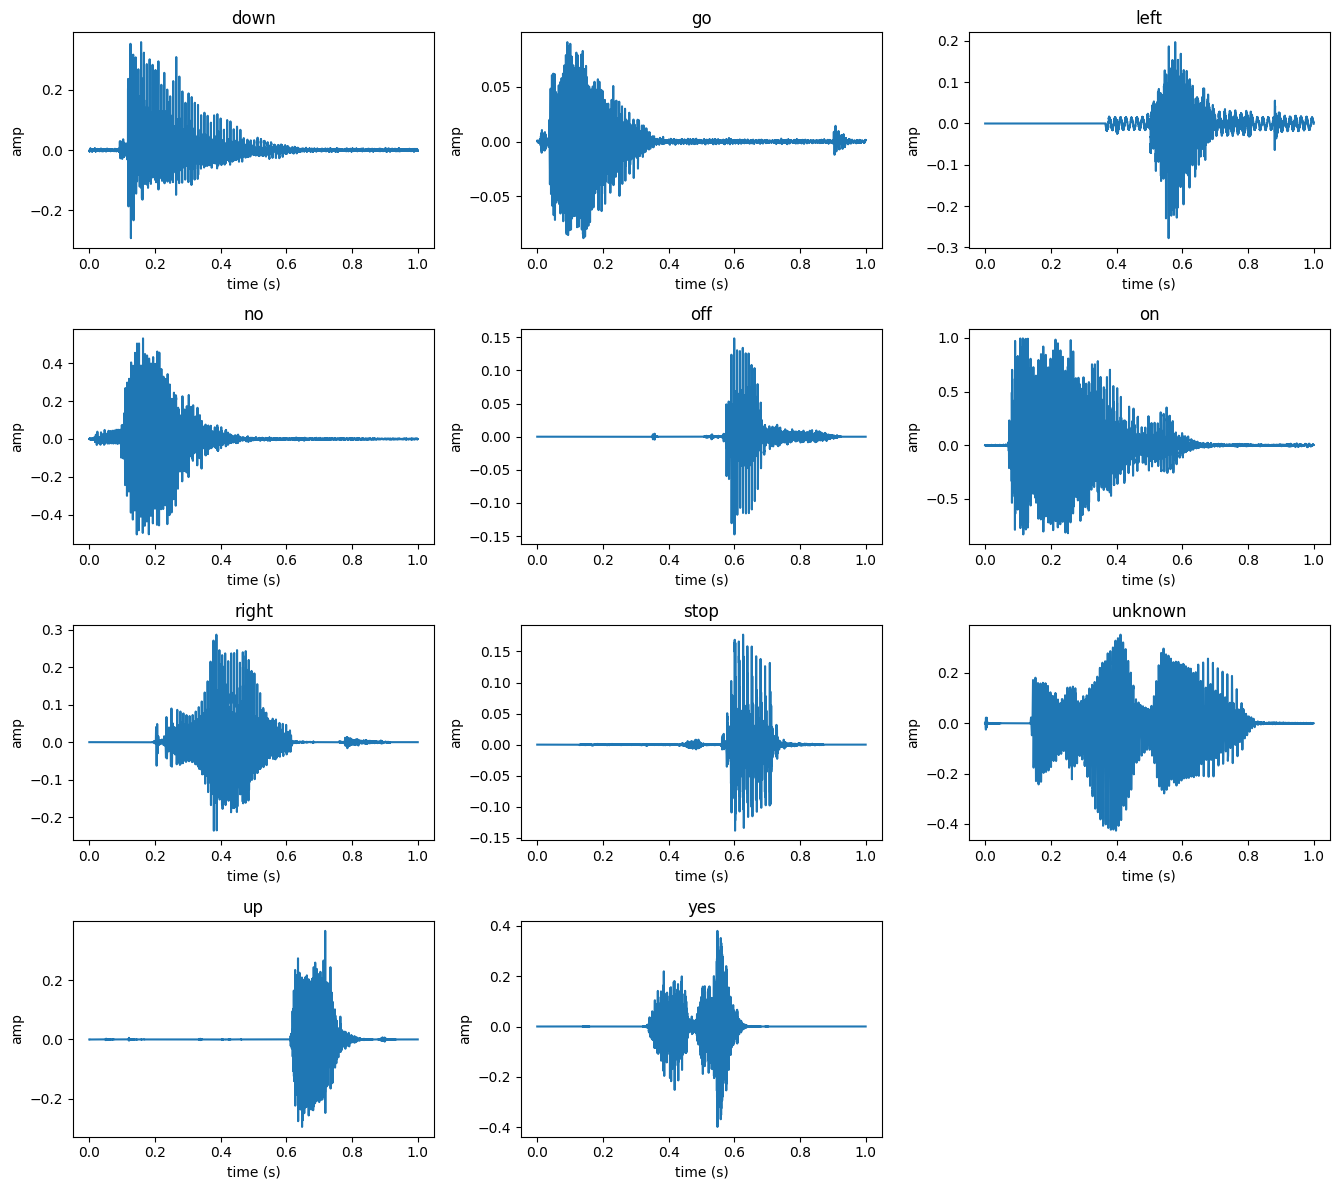

In [10]:
def show_random_example_per_class(dataset, n_cols=3):
    labels = sorted({e["label"] for e in dataset})
    n_rows = math.ceil(len(labels) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols * 4.5, n_rows * 3))
    axes = axes.flat

    for ax, label in zip(axes, labels):
        ex = random.choice([e for e in dataset if e["label"] == label])
        wav, sr = load_audio(ex["file_path"])
        wav = normalize_audio_duration(wav, sr)           # 1-s crop/pad

        t = np.arange(len(wav)) / sr
        ax.plot(t, wav)
        ax.set_title(label)
        ax.set_xlabel("time (s)")
        ax.set_ylabel("amp")

        print(label)
        display(Audio(wav, rate=sr))
    
    # hide any empty subplots
    for ax in axes[len(labels):]:
        ax.axis("off")
    plt.tight_layout()

show_random_example_per_class(train)

## Models and training

In [11]:
batch_size = 64

train_ds = TensorDataset(X_train, y_train)
val_ds   = TensorDataset(X_val,   y_val)
test_ds  = TensorDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"{len(train_loader)=}, {len(val_loader)=}, {len(test_loader)=}")

len(train_loader)=72, len(val_loader)=11, len(test_loader)=10


### Baseline CNN

In [12]:
class ConvBaseline(nn.Module):
    """
    Extremely small CNN => ~120 k params.
    """
    def __init__(self, n_classes=len(id2label)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                              # (20, 50)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                              # (10, 25)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1, 1))                  # (128, 1, 1)
        )
        self.classifier = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.net(x).flatten(1)
        return self.classifier(x)

In [13]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss, correct, count = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(xb)
            loss   = criterion(logits, yb)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * len(xb)
        correct    += (logits.argmax(1) == yb).sum().item()
        count      += len(xb)

    return total_loss / count, correct / count

In [14]:
def eval_model(model, test_loader, label=None):
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb.to(device)).argmax(1).cpu()
            all_preds.append(pred)
            all_true.append(yb)
    all_preds = torch.cat(all_preds).numpy()
    all_true  = torch.cat(all_true).numpy()
    
    acc = (all_preds == all_true).mean()
    print(f"Test accuracy: {acc:.3%}")
    
    cm = confusion_matrix(all_true, all_preds, labels=list(id2label.keys()))
    disp = ConfusionMatrixDisplay(cm, display_labels=[id2label[i] for i in id2label])
    fig, ax = plt.subplots(figsize=(7, 7))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    if label is not None:
        ax.set_title(f"Confusion matrix – {label}")
    plt.show()

In [15]:
epochs = 12
cnn_model  = ConvBaseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

for ep in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(cnn_model, train_loader, criterion, optimizer)
    val_loss,   val_acc   = run_epoch(cnn_model, val_loader,   criterion)
    scheduler.step()

    print(f"Epoch {ep:02d}/{epochs} | "
          f"train {train_loss:.4f}/{train_acc:.3f} – "
          f"val {val_loss:.4f}/{val_acc:.3f}")

Epoch 01/12 | train 2.2315/0.262 – val 2.0448/0.385
Epoch 02/12 | train 1.9407/0.446 – val 1.7909/0.506
Epoch 03/12 | train 1.6988/0.545 – val 1.6070/0.581
Epoch 04/12 | train 1.4979/0.616 – val 1.4437/0.620
Epoch 05/12 | train 1.3204/0.675 – val 1.2544/0.648
Epoch 06/12 | train 1.1770/0.714 – val 1.1709/0.676
Epoch 07/12 | train 1.0599/0.744 – val 1.0714/0.702
Epoch 08/12 | train 0.9934/0.758 – val 1.0534/0.741
Epoch 09/12 | train 0.9348/0.780 – val 0.9977/0.720
Epoch 10/12 | train 0.8870/0.791 – val 0.9504/0.743
Epoch 11/12 | train 0.8423/0.799 – val 0.9321/0.743
Epoch 12/12 | train 0.7999/0.817 – val 0.8940/0.760


Test accuracy: 76.250%


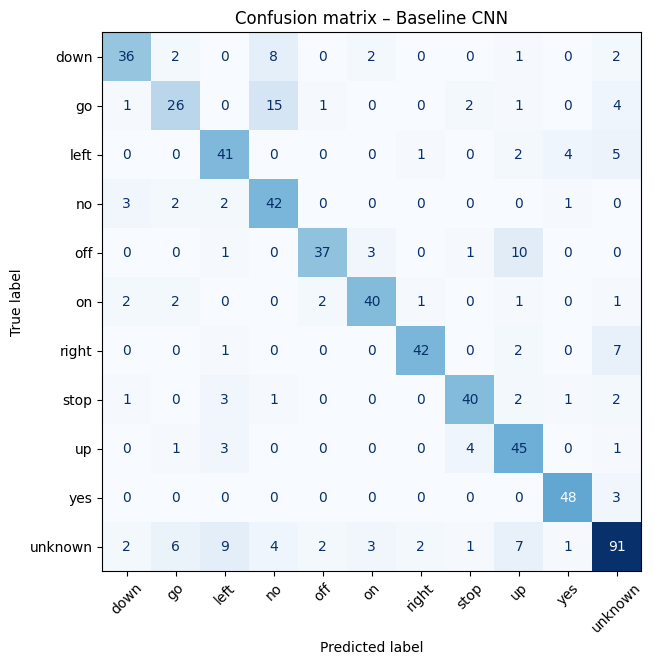

In [16]:
eval_model(cnn_model, test_loader, 'Baseline CNN')

### Transformer

In [17]:
class PositionalEncoding(nn.Module):
    """
    Classic sine/cos positional encodings.
    Expects input shape (B, T, D).
    """
    def __init__(self, d_model: int, max_len: int = 1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10_000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, T, D)
        return x + self.pe[:, : x.size(1)]

In [18]:
class TransformerClassifier(nn.Module):
    def __init__(self,
                 n_mfcc=40, n_classes=len(id2label),
                 d_model=128, n_heads=4,
                 num_layers=4, dim_ff=256,
                 dropout=0.1, pool="cls"):
        super().__init__()
        self.pool = pool

        self.input_proj = nn.Linear(n_mfcc, d_model)
        self.pos_enc    = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads,
            dim_feedforward=dim_ff, dropout=dropout,
            batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer,
                                             num_layers=num_layers)

        if pool == "cls":
            self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):                     # x: (B, 40, 101)
        x = x.transpose(1, 2)                 #      (B, 101, 40)
        x = self.input_proj(x)                #      (B, 101, d_model)

        if self.pool == "cls":
            cls = self.cls_token.expand(x.size(0), -1, -1)  # (B,1,d_model)
            x   = torch.cat([cls, x], dim=1)                # (B, 102, d_model)

        x = self.pos_enc(x)
        x = self.encoder(x)                   # (B, T, d_model)

        rep = x[:, 0] if self.pool == "cls" else x.mean(1)
        return self.classifier(rep)

In [19]:
tfm_model = TransformerClassifier(
    n_mfcc=40,
    d_model=128,
    n_heads=4,
    num_layers=4,
    dim_ff=256,
    dropout=0.1,
    pool="cls"             # or "mean"
).to(device)

criterion  = nn.CrossEntropyLoss()
optimizer  = optim.AdamW(tfm_model.parameters(), lr=2e-4, weight_decay=1e-2)
scheduler  = StepLR(optimizer, step_size=8, gamma=0.5)

In [20]:
epochs = 12

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(tfm_model, train_loader, criterion, optimizer)
    v_loss,  v_acc  = run_epoch(tfm_model,   val_loader, criterion)
    scheduler.step()

    print(f"[{ep:02d}/{epochs}] "
          f"train {tr_loss:.4f}/{tr_acc:.3f} – "
          f"val {v_loss:.4f}/{v_acc:.3f}")

[01/12] train 2.3544/0.191 – val 2.2556/0.199
[02/12] train 2.0023/0.268 – val 1.7380/0.361
[03/12] train 1.6354/0.413 – val 1.4114/0.523
[04/12] train 1.3886/0.516 – val 1.2338/0.579
[05/12] train 1.2054/0.582 – val 1.1788/0.614
[06/12] train 1.0749/0.632 – val 1.0064/0.667
[07/12] train 0.9431/0.686 – val 0.9199/0.664
[08/12] train 0.8755/0.709 – val 0.8538/0.702
[09/12] train 0.7740/0.742 – val 0.8294/0.713
[10/12] train 0.7325/0.760 – val 0.7555/0.731
[11/12] train 0.6830/0.781 – val 0.7496/0.743
[12/12] train 0.6558/0.787 – val 0.7527/0.741


Test accuracy: 74.375%


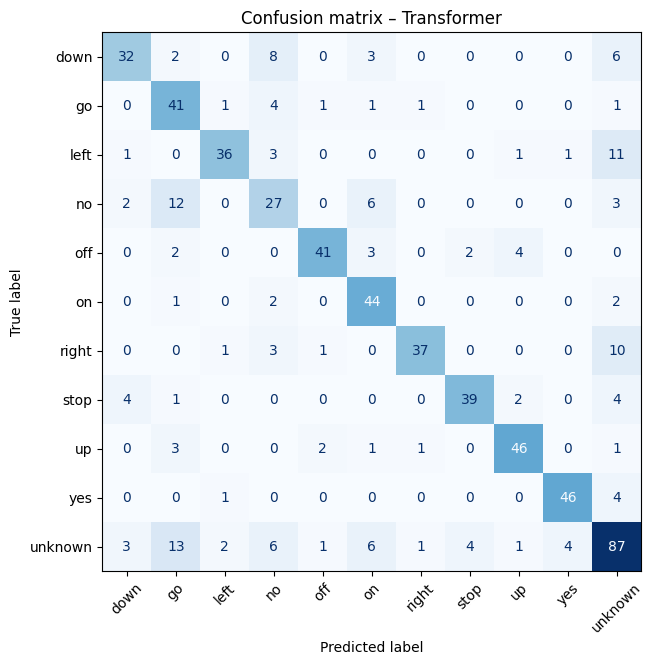

In [21]:
eval_model(tfm_model, test_loader, 'Transformer')